In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
print(keras.__version__)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from math import nan
from keras.callbacks import ModelCheckpoint

!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers import CRF

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

2.2.4
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-6w9n305p
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-6w9n305p
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=53a6ea9790672f427994a36b9a18c0e9902a47bb7a7b7daedb1ec68239750f7f
  Stored in directory: /tmp/pip-ephem-wheel-cache-3efv6ne7/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
entity-annotated-corpus




## Importing the dataset for named entity recognition model

In [3]:
dframe = pd.read_csv("../input/entity-annotated-corpus/ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [4]:
dframe

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O
5,5,through,london,to,TO,lowercase,to,NNP,capitalized,London,...,have,VBP,lowercase,have,lowercase,marched,1.0,lowercase,through,O
6,6,london,to,protest,VB,lowercase,protest,TO,lowercase,to,...,march,VBN,lowercase,marched,lowercase,through,1.0,capitalized,London,B-geo
7,7,to,protest,the,DT,lowercase,the,VB,lowercase,protest,...,through,IN,lowercase,through,capitalized,London,1.0,lowercase,to,O
8,8,protest,the,war,NN,lowercase,war,DT,lowercase,the,...,london,NNP,capitalized,London,lowercase,to,1.0,lowercase,protest,O
9,9,the,war,in,IN,lowercase,in,NN,lowercase,war,...,to,TO,lowercase,to,lowercase,protest,1.0,lowercase,the,O


## Data preprocessing

In [5]:
dframe.columns

Index(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'pos', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word', 'sentence_idx', 'shape',
       'word', 'tag'],
      dtype='object')

## We want word, pos, sentence_idx and tag as an input 

In [6]:
dataset=dframe.drop(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word',"pos"],axis=1)

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050795 entries, 0 to 1050794
Data columns (total 4 columns):
sentence_idx    1050794 non-null float64
shape           1050794 non-null object
word            1050794 non-null object
tag             1050794 non-null object
dtypes: float64(1), object(3)
memory usage: 32.1+ MB


In [8]:
dataset.head()

,sentence_idx,shape,word,tag
0,1.0,capitalized,Thousands,O
1,1.0,lowercase,of,O
2,1.0,lowercase,demonstrators,O
3,1.0,lowercase,have,O
4,1.0,lowercase,marched,O


In [9]:
dataset=dataset.drop(['shape'],axis=1)

In [10]:
dataset.head()

,sentence_idx,word,tag
0,1.0,Thousands,O
1,1.0,of,O
2,1.0,demonstrators,O
3,1.0,have,O
4,1.0,marched,O


## Create list of list of tuples to differentiate each sentence from each other

In [11]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [12]:
getter = SentenceGetter(dataset)

In [13]:
sentences = getter.sentences

In [14]:
print(sentences[5])
print(len(sentences))

[('The', 'O'), ('party', 'O'), ('is', 'O'), ('divided', 'O'), ('over', 'O'), ('Britain', 'B-gpe'), ("'s", 'O'), ('participation', 'O'), ('in', 'O'), ('the', 'O'), ('Iraq', 'B-geo'), ('conflict', 'O'), ('and', 'O'), ('the', 'O'), ('continued', 'O'), ('deployment', 'O'), ('of', 'O'), ('8,500', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('in', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O'), ('The', 'O'), ('party', 'O'), ('is', 'O'), ('divided', 'O'), ('over', 'O'), ('Britain', 'B-gpe'), ("'s", 'O'), ('participation', 'O'), ('in', 'O'), ('the', 'O'), ('Iraq', 'B-geo'), ('conflict', 'O'), ('and', 'O'), ('the', 'O'), ('continued', 'O'), ('deployment', 'O'), ('of', 'O'), ('8,500', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('in', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]
35177


In [15]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 140


In [16]:
# Check how long sentences are so that we can pad them
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

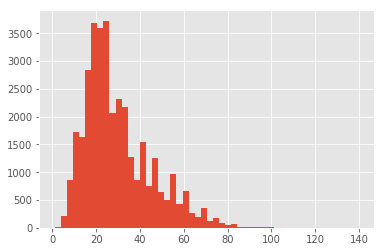

In [17]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [18]:
words = list(set(dataset["word"].values))
words.append("ENDPAD")

In [19]:
n_words = len(words); n_words

30174

## Fix the tags

In [20]:
tags = []
for tag in set(dataset["tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
print(tags)

['B-geo', 'B-gpe', 'I-per', 'I-org', 'I-gpe', 'unk', 'B-tim', 'B-per', 'I-nat', 'I-eve', 'O', 'B-art', 'I-tim', 'B-nat', 'B-org', 'I-geo', 'B-eve', 'I-art']


In [21]:
n_tags = len(tags); n_tags

18

**Converting words to numbers and numbers to words**

In [22]:
from future.utils import iteritems
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

print(tag2idx)

{'B-geo': 0, 'B-gpe': 1, 'I-per': 2, 'I-org': 3, 'I-gpe': 4, 'unk': 5, 'B-tim': 6, 'B-per': 7, 'I-nat': 8, 'I-eve': 9, 'O': 10, 'B-art': 11, 'I-tim': 12, 'B-nat': 13, 'B-org': 14, 'I-geo': 15, 'B-eve': 16, 'I-art': 17}


In [23]:
word2idx['Obama']

13749

In [24]:
tag2idx["O"]

10

In [25]:
tag2idx

{'B-geo': 0,
 'B-gpe': 1,
 'I-per': 2,
 'I-org': 3,
 'I-gpe': 4,
 'unk': 5,
 'B-tim': 6,
 'B-per': 7,
 'I-nat': 8,
 'I-eve': 9,
 'O': 10,
 'B-art': 11,
 'I-tim': 12,
 'B-nat': 13,
 'B-org': 14,
 'I-geo': 15,
 'B-eve': 16,
 'I-art': 17}

In [26]:
idx2tag[5]

'unk'

In [27]:
idx2tag

{0: 'B-geo',
 1: 'B-gpe',
 2: 'I-per',
 3: 'I-org',
 4: 'I-gpe',
 5: 'unk',
 6: 'B-tim',
 7: 'B-per',
 8: 'I-nat',
 9: 'I-eve',
 10: 'O',
 11: 'B-art',
 12: 'I-tim',
 13: 'B-nat',
 14: 'B-org',
 15: 'I-geo',
 16: 'B-eve',
 17: 'I-art'}

In [28]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [29]:
np.array(X).shape

(35177,)

In [30]:
X = pad_sequences(maxlen=140, sequences=X, padding="post",value=n_words - 1)

In [31]:
y_idx = [[tag2idx[w[1]] for w in s] for s in sentences]
print(sentences[100])
print(y_idx[100])

[('The', 'O'), ('Pakistani', 'B-gpe'), ('military', 'O'), ('launched', 'O'), ('its', 'O'), ('offensive', 'O'), ('in', 'O'), ('Orakzai', 'B-geo'), ('to', 'O'), ('hunt', 'O'), ('Taliban', 'B-org'), ('insurgents', 'O'), ('.', 'O'), ('The', 'O'), ('Pakistani', 'B-gpe'), ('military', 'O'), ('launched', 'O'), ('its', 'O'), ('offensive', 'O'), ('in', 'O'), ('Orakzai', 'B-geo'), ('to', 'O'), ('hunt', 'O'), ('Taliban', 'B-org'), ('insurgents', 'O'), ('.', 'O')]
[10, 1, 10, 10, 10, 10, 10, 0, 10, 10, 14, 10, 10, 10, 1, 10, 10, 10, 10, 10, 0, 10, 10, 14, 10, 10]


In [32]:
y = pad_sequences(maxlen=140, sequences=y_idx, padding="post", value=tag2idx["O"])
print(y_idx[100])


[10, 1, 10, 10, 10, 10, 10, 0, 10, 10, 14, 10, 10, 10, 1, 10, 10, 10, 10, 10, 0, 10, 10, 14, 10, 10]


In [33]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]


In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


## Import Keras

In [35]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k

## Keras version

In [36]:
print(k.__version__)

2.2.4


## Model
 **Pay attention to the word embedding size

In [37]:
input = Input(shape=(140,))
word_embedding_size = 300
model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=140)(input)
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(model)
model = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  # previously softmax output layer

crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

In [38]:
model = Model(input, out)

In [39]:
adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
#model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])

/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 140)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 140, 300)          9052200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 140, 600)          1442400   
_________________________________________________________________
lstm_2 (LSTM)                (None, 140, 600)          2882400   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 140, 18)           10818     
_________________________________________________________________
crf_1 (CRF)                  (None, 140, 18)           702       
Total params: 13,388,520
Trainable params: 13,388,520
Non-trainable params: 0
________________________________________________________________

## Save the model after each epoch if validation is better

In [41]:
# Saving the best only
filepath="ner-bi-lstm-td-model-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

## Fit

In [42]:
history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=20, validation_split=0.2, verbose=1, callbacks=callbacks_list)

Train on 22512 samples, validate on 5629 samples
Epoch 1/20
22512/22512 [==============================] - 119s 5ms/step - loss: 0.3962 - crf_viterbi_accuracy: 0.9272 - acc: 0.0075 - val_loss: 0.1885 - val_crf_viterbi_accuracy: 0.9668 - val_acc: 0.9668

Epoch 00001: val_acc improved from -inf to 0.96684, saving model to ner-bi-lstm-td-model-0.97.hdf5
Epoch 2/20
22512/22512 [==============================] - 106s 5ms/step - loss: 0.1604 - crf_viterbi_accuracy: 0.9674 - acc: 0.0075 - val_loss: 0.1300 - val_crf_viterbi_accuracy: 0.9669 - val_acc: 0.9669

Epoch 00002: val_acc improved from 0.96684 to 0.96689, saving model to ner-bi-lstm-td-model-0.97.hdf5
Epoch 3/20
22512/22512 [==============================] - 105s 5ms/step - loss: 0.1026 - crf_viterbi_accuracy: 0.9697 - acc: 0.0075 - val_loss: 0.0859 - val_crf_viterbi_accuracy: 0.9744 - val_acc: 0.9744

Epoch 00003: val_acc improved from 0.96689 to 0.97442, saving model to ner-bi-lstm-td-model-0.97.hdf5
Epoch 4/20
22512/22512 [=========

## Accumulate metrics by tag 

In [ ]:
TP = {}
TN = {}
FP = {}
FN = {}
for tag in tag2idx.keys():
    TP[tag] = 0
    TN[tag] = 0    
    FP[tag] = 0    
    FN[tag] = 0    

print("??")
def accumulate_score_by_tag(gt, pred):
    """
    For each tag keep stats
    """
    if gt == pred:
        TP[gt] += 1
    elif gt != 'O' and pred == 'O':
        FN[gt] +=1
    elif gt == 'O' and pred != 'O':
        FP[gt] += 1
    else:
        TN[gt] += 1

print("?")

## Single prediction and verbose results

In [44]:
i = 357
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
gt = np.argmax(y_test[i], axis=-1)
print(gt)
print("{:14}: ({:5}): {}".format("Word", "True", "Pred"))
for idx, (w,pred) in enumerate(zip(X_test[i],p[0])):
    #
    print("{:14}: ({:5}): {}".format(words[w],idx2tag[gt[idx]],tags[pred]))

[10 10 10 10 14  3  7  2 10 10 10 10  0 10 10  6 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
Word          : (True ): Pred
The           : (O    ): O
statement     : (O    ): O
came          : (O    ): O
as            : (O    ): O
U.N.          : (B-org): B-org
Secretary-General: (I-org): I-org
Kofi          : (B-per): B-per
Annan         : (I-per): I-per
met           : (O    ): O
with          : (O    ): O
officials     : (O    ): O
in            : (O    ): O
Amman         : (B-geo): B-geo
to            : (O    ): O
discuss       : (O    ): O
Wednesday     : (B-tim): B-tim
's            : (O    ): O
attacks       : (O    ): O
.             : (O    ): O
END

## Predict everything at once

In [ ]:
p = model.predict(np.array(X_test))  

## The output is 3d: sent x word x tag prob (softmax)

In [ ]:
p.shape

## Standard Classification Report

In [ ]:
from sklearn.metrics import classification_report

Grab the 3d dimension and return the index of the highest probability ... the index matches the tag value
np.argmax(p, axis=2)

In [ ]:
np.argmax(p, axis=2)[0]

In [ ]:
print(classification_report(np.argmax(y_test, 2).ravel(), np.argmax(p, axis=2).ravel(),labels=list(idx2tag.keys()), target_names=list(idx2tag.values())))

## Accumulate the scores by tag

In [ ]:
for i, sentence in enumerate(X_test):
    y_hat = np.argmax(p[i], axis=-1)
    gt = np.argmax(y_test[i], axis=-1)
    for idx, (w,pred) in enumerate(zip(sentence,y_hat)):
        accumulate_score_by_tag(idx2tag[gt[idx]],tags[pred])

## How did Classification perform for each tag

In [ ]:
for tag in tag2idx.keys():
    print(f'tag:{tag}')    
    print('\t TN:{:10}\tFP:{:10}'.format(TN[tag],FP[tag]))
    print('\t FN:{:10}\tTP:{:10}'.format(FN[tag],TP[tag]))    